# Exercise 2: Manifold Learning

**Note**: Please insert the names of all participating students:

1.
2.
3.
4.
5.

In [1]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs5450.git'
    os.chdir('cs5450')

## Exercise 2.1: Multi-dimensional Scaling (MDS)

In this exercise, we will implement Multi-dimensional Scaling.

Implement the missing parts below. When done correctly, your code should do the following:
1. Generate a swiss roll dataset.
2. Compute the squared euclidean distances between samples.
3. Compute the gram matrix from squared distances and the centering matrix.
4. Sort the eigenvalues and corresponding eigenvectors of the gram matrix.
5. Calculate the MDS data representation with reduced dimensions.
6. Show the lower-dimensional representation of the data.

In case you are struggeling with the task, here are some helpful tips and hints:
1. Useful functions: [`make_swiss_roll`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_swiss_roll.html), [`pdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html), [`squareform`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html), [`numpy.eye`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html), [`numpy.ones`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ones.html), [`numpy.linalg.eig`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html), [`numpy.argsort`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html), [`numpy.sqrt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sqrt.html), [`numpy.diag`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html), [`Axes.scatter`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter), [`Axes3D.scatter`](https://matplotlib.org/3.1.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html#mpl_toolkits.mplot3d.axes3d.Axes3D.scatter)

2. Additional references: [Color maps for matplotlib](https://matplotlib.org/examples/color/colormaps_reference.html)

Note: Don't use the MDS implementation provided by the sklearn package here.

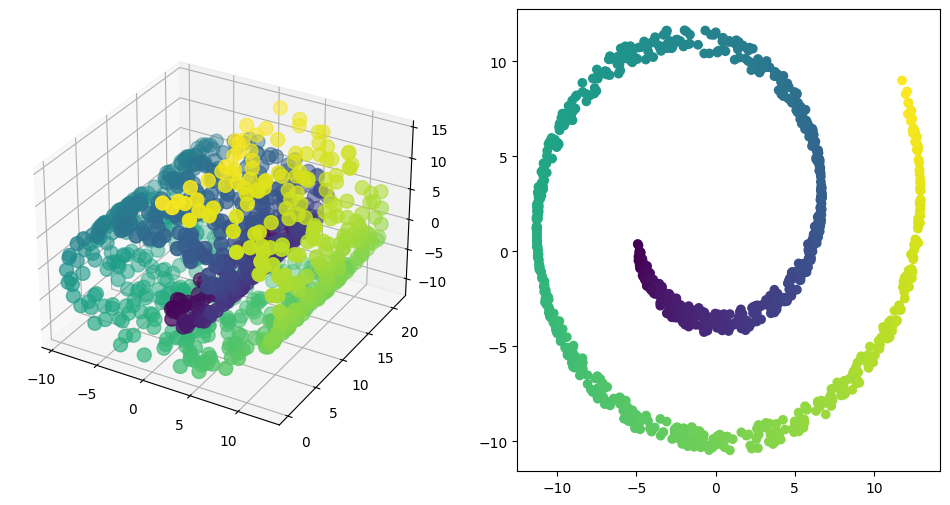

In [29]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_swiss_roll

#%matplotlib inline

# ---------- USE FOR INTERACTIVE PLOTS --------------------------
#%matplotlib notebook
#%matplotlib nbagg
%matplotlib inline


# ---------------------------------------------------------------

## Define variables

# TODO n_samples : number of random samples (observations)
n_samples = 1000

# n_dims : number of dimensions of the embedding
n_dims = 2

## Compute and visualize the embedding using MDS

# TODO generate data (make_swiss_roll)
data, color = make_swiss_roll(n_samples=n_samples)
# TODO compute euclidean distance vector (pdist)
distances = pdist(data, 'euclidean')
# TODO reshape into distance matrix (squareform)
distances = squareform(distances)

# TODO square the distances inside the matrix
distances_squared = distances ** 2

# TODO calculate the centering matrix H (c.f. page 15)
I = np.eye(n_samples)
O = np.ones((n_samples, n_samples))
centering = I - (1/n_samples)*O
# TODO compute the gram matrix B (c.f. page 15)
gram = -0.5 * np.matmul(np.matmul(centering, distances_squared), centering)
# TODO compute its eigenvectors and eigenvalues (eig)
eig_values, eig_vectors = np.linalg.eigh(gram)

# TODO sort the eigenvalues and its corresponding eigenvectors (descending!)
permutation = np.argsort(eig_values)[::-1] # calculate permutation indices for the sorted eigenvalues
eig_vectors = eig_vectors[:, permutation]# rearrange eigenvectors according to permutation
eig_values = eig_values[permutation] # rearrange eigenvalues according to permutation

# TODO calculate the square root of the eigenvalues (note: add offset to avoid negative numbers from small numerical errors)
epsilon = 0.001
eig_values_root = np.sqrt(np.maximum(eig_values, 0) + epsilon)

# TODO reduce dimensions (c.f. equation 1.20)
data_mds = np.matmul(eig_vectors[:, :n_dims], np.diag(eig_values_root[:n_dims]))

# TODO visualize both the original data and its embedding (add_subplot, scatter)
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121, projection='3d') #get Axes3D object for subplot
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, cmap='viridis', s=100) #3d plot here

ax = fig.add_subplot(122) #get Axes object for subplot
ax.scatter(data_mds[:, 0], data_mds[:, 1], c=color, cmap='viridis') # 2d plot here
plt.show()

## Exercise 2.2: Isomap

In this exercise, we will be implementing the Isomap algorithm.

You can use the MDS implementation from sklearn within your Isomap implementation.

Implement the missing parts below. When done correctly, your code should do the following:
1. Generate a swiss roll dataset.
2. Compute the euclidean distances between samples.
3. Sort the neighbors of each sample by distance.
4. Keep the closest k neighbors of each sample and set all other distances to infinity or NaN or zero to mark them as not-connected.
5. Calculate all shortest paths between pairs of samples (representing geodesic distances on the manifold).
6. Calculate the MDS data representation with reduced dimensions on the geodesic distances.
7. Show the lower-dimensional representation of the data.

In case you are struggeling with the task, here are some helpful tips and hints:
1. Useful functions:[`csgraph_from_dense`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.csgraph_from_dense.html), [`shortest_path`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.shortest_path.html#scipy.sparse.csgraph.shortest_path), [`MDS`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
2. Make sure to use MDS with `dissimilarity='precomputed'` so that it takes a distance matrix as input instead of a matrix of sample coordinates.

In [66]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import csgraph_from_dense, shortest_path
from sklearn.manifold import MDS
from sklearn.datasets import make_swiss_roll

## Define variables

# TODO n_samples : number of random samples (observations)
n_samples = 1000

# n_dims : number of dimensions of the embedding
n_dims = 2

# TODO n_neighbors : number of nearest neighbors (k)
n_neighbors = 10


## Compute and visualize the embedding using Isomap

# TODO generate data (make_swiss_roll)
data, color = make_swiss_roll(n_samples=n_samples)
# TODO compute euclidean distance vector (pdist)
distances = pdist(data, 'euclidean')
print(distances[0,])
# TODO reshape into distance matrix (squareform)
distances = squareform(distances)
# TODO find the nearest neighbor-indices (argsort)
permutation = np.argsort(distances) # sort along one dim and get indices for permutation

# TODO create the local distance matrix (only to the nearest neighbors)
# All other values must be zero
distances_local = np.zeros((n_samples, n_samples)) # initialize
for i in range(n_samples):
   # TODO: write the K-NNs (of the i-th row) distances to the position of K-NNs
   indices = permutation[i, :n_neighbors+1]
   distances_local[i,indices] = distances[i, indices]

# enforce distances_local to be symmetric
distances_local_transposed = distances_local.T
# get all entries that should be !=0 but are not in the current dist mat
mask = (distances_local == 0) & (distances_local_transposed != 0);
distances_local[mask] = distances_local_transposed[mask]

# TODO compute shortest paths
# output: [D(i,j)], where D(i,j) = distance from node 'i' to node 'j'
distances_geodesic = shortest_path(csgraph_from_dense(distances_local))
assert not np.any(np.isinf(distances_geodesic)), 'Error: manifold is fragmented into multiple disconnected regions.'

#plt.show()

23.637865811971896


/Users/cgathmann/Library/Python/3.10/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


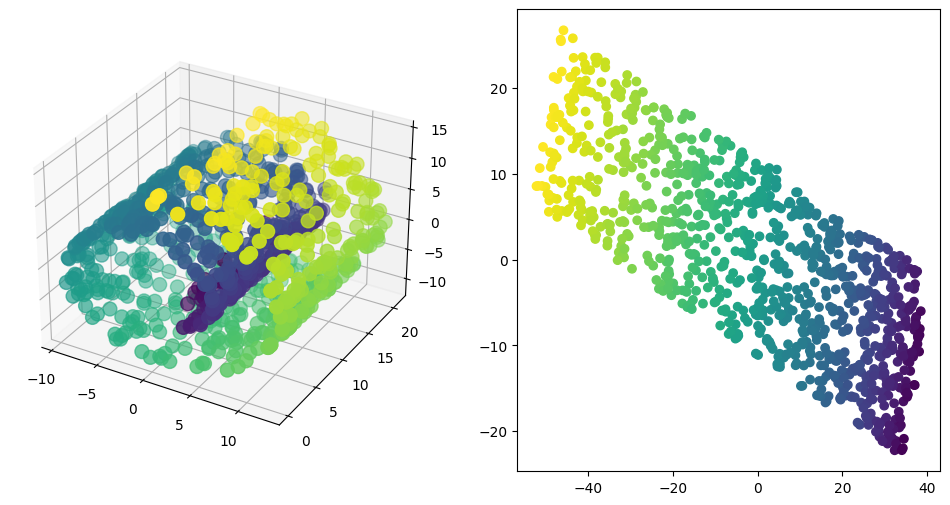

In [67]:
# TODO classical multidimensional scaling (MDS)
embedding = MDS(n_components=n_dims, dissimilarity='precomputed')
data_isomap = embedding.fit_transform(distances_geodesic)

# TODO visualize both the original data and its embedding (add_subplot, scatter)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color, cmap='viridis', s=100) #3d plot here

ax = fig.add_subplot(122) #get Axes object for subplot
ax.scatter(data_isomap[:, 0], data_isomap[:, 1], c=color, cmap='viridis')

## Exercise 2.3: Comprehension Questions

Answer the following comprehension questions either with right or wrong and briefly explain your decision:

1. A manifold is a topological space that locally resembles Euclidean space near each point, e.g. a sphere.

Correct. As we only observe small neighborhoods.

2. The features found by classical MDS are equivalent to the ones computed by ICA.

Wrong. MDS tries to keep relationships in small neighborhoods while ICA searches for statistically independent data

3. Isomap replaces the Euclidean distance measure used by MDS with geodesic distances.

Correct.

4. Local Linear Embedding (LLE) seeks a lower-dimensional projection of the data trying to preserve the distances within a local neighborhood.

Correct.

5. Unlike MDS, LLE uses global properties of the manifold to find an embedding.

Wrong. LLE tries to keep local relationships. 

6. $n+1$ non-collinear points of two distinct classes are always linearly separable in $\mathbb{R}^n$.

Correct. By constructing a hyperplane in $\mathbb{R}^n$ the $n+1$ points can be separated.

7. The reason that the kernel trick can be applied is that the observations only show up in pairs of inner products.

Correct. This allows for the creation of a kernel function that maps the data to higher dimensions.

8. To apply the kernel trick, the function $\boldsymbol{\Phi} \left( \vec{x} \right)$ must be explicitly known.

Wrong. Instead you only need to know the kernel function that calculates the inner products in the transformed space directly.

9. The function $\boldsymbol{\Phi} \left( \vec{x} \right) = \boldsymbol{\Phi} \left( \left[x_1, x_2 \right] \right) = \left[ x_1^2, \sqrt{2} x_1 x_2, x_2^2\right]$ is a function of the kernel $K \left( \vec{x}, \vec{y} \right) = \langle \vec{x}, \vec{y}\rangle^2$. This function is unique.

Correct. $\boldsymbol{\Phi}$ is a function of $K$.